# Analyse des votes des députés par MCMC

## 1. Bibliothèques utilisées

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pymc3 as pm
import plotly.express as px
from scipy.stats import pearsonr
from IPython.display import clear_output, display
from sklearn.model_selection import train_test_split

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 2. Entrainement du modèle MCMC

L'objectif est ici d'entrainer un modèle MCMC à partir des données issues des votes des député.e.s à l'Assemblée nationale.
Nous allons tout d'abord importer les données de votes issues de 00_ExtractionVotesDeputes.
Nous allons en suis retraiter ces données en remplaçant les votes "pour" par 1 et les autres par 0.
Enfin nous lancerons l'entrainement du modèle MCMC.

In [2]:
# Importer les données issues des votes des député.e.s de l'Assemblée nationale
df = pd.read_csv("data\\20230430_Data_Votes_Deputes.csv")
df

,identifiant,Prénom,Nom,Région,Département,Numéro de circonscription,Profession,Groupe politique (complet),Groupe politique (abrégé),VTANR5L16V1,...,VTANR5L16V990,VTANR5L16V991,VTANR5L16V992,VTANR5L16V993,VTANR5L16V994,VTANR5L16V995,VTANR5L16V996,VTANR5L16V997,VTANR5L16V998,VTANR5L16V999
0,PA642868,Paul,Christophe,Hauts-de-France,Nord,14,Fonctionnaire de catégorie A,Horizons et apparentés,HOR,NaN,...,contres,contres,contres,contres,contres,contres,contres,contres,contres,contres
1,PA719146,Jean-Félix,Acquaviva,Corse,Haute-Corse,2,Cadre,"Libertés, Indépendants, Outre-mer et Territoires",LIOT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PA795692,William,Martinet,Ile-de-France,Yvelines,11,Cadre administratif,La France insoumise - Nouvelle Union Populaire...,LFI - NUPES,pours,...,NaN,pours,pours,pours,pours,pours,pours,pours,pours,pours
3,PA795050,Astrid,Panosyan-Bouvet,Ile-de-France,Paris,4,Cadre administratif et commercial d'entreprise,Renaissance,RE,NaN,...,contres,contres,contres,contres,contres,contres,contres,contres,contres,contres
4,PA719412,Sandrine,Le Feur,Bretagne,Finistère,4,Agriculteur-propriétaire exploitant,Renaissance,RE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,PA793664,Marie,Pochon,Auvergne-Rhône-Alpes,Drôme,3,Responsable associative,Écologiste - NUPES,Ecolo - NUPES,pours,...,NaN,pours,pours,pours,pours,pours,pours,pours,NaN,NaN
573,PA721182,Frédéric,Petit,Français établis hors de France,Français établis hors de France,7,Ingénieur,Démocrate (MoDem et Indépendants),Dem,NaN,...,contres,contres,contres,contres,contres,contres,contres,contres,contres,contres
574,PA757225,Mikaele,Seo,Wallis-et-Futuna,Wallis-et-Futuna,1,Profession intermédiaire administrative de la ...,Renaissance,RE,NaN,...,NaN,contres,contres,contres,contres,contres,contres,contres,NaN,NaN
575,PA794802,Charles,Sitzenstuhl,Grand Est,Bas-Rhin,5,Cadre de la fonction publique,Renaissance,RE,NaN,...,contres,contres,contres,contres,contres,contres,contres,contres,contres,contres


### 2.1. Echantillonnage des votes

Lancer l'entrainement du modèle avec l'ensemble des votes et des députés prendrait plus de 4 jours à compiler avec le matériel à notre disposition.
Nous allons donc réaliser un échantillonnage stratifié pour obtenir une trentaine de député.e.s avant de lancer l'entrainement de notre modèle.

In [3]:
# Séparation des données en groupes politiques distincts
groupes_politiques = df.groupby('Groupe politique (abrégé)')

# Initialisation des tableaux pour les données d'entraînement et de test
df = pd.DataFrame()

# Pour chaque groupe politique, on réalise un échantillonnage stratifié
for groupe, data in groupes_politiques:
    X = data.drop('Groupe politique (abrégé)', axis=1)
    y = data['Groupe politique (abrégé)']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, stratify=y, random_state=42)
    df = pd.concat([df, pd.concat([X_test, y_test], axis=1)], ignore_index=True)

In [4]:
df

,identifiant,Prénom,Nom,Région,Département,Numéro de circonscription,Profession,Groupe politique (complet),VTANR5L16V1,VTANR5L16V10,...,VTANR5L16V991,VTANR5L16V992,VTANR5L16V993,VTANR5L16V994,VTANR5L16V995,VTANR5L16V996,VTANR5L16V997,VTANR5L16V998,VTANR5L16V999,Groupe politique (abrégé)
0,PA719822,Sabine,Thillaye,Centre-Val de Loire,Indre-et-Loire,5,Ancien Chef d'entreprise,Démocrate (MoDem et Indépendants),NaN,contres,...,contres,contres,contres,contres,contres,contres,contres,contres,contres,Dem
1,PA720334,Jimmy,Pahun,Bretagne,Morbihan,2,Navigateur,Démocrate (MoDem et Indépendants),NaN,contres,...,contres,contres,contres,contres,contres,contres,contres,contres,contres,Dem
2,PA331582,Philippe,Vigier,Centre-Val de Loire,Eure-et-Loir,4,Biologiste A.I.H.P.,Démocrate (MoDem et Indépendants),NaN,contres,...,contres,contres,contres,contres,contres,contres,contres,contres,NaN,Dem
3,PA795794,Francesca,Pasquini,Ile-de-France,Hauts-de-Seine,2,"Professeur des écoles, instituteur et assimilé",Écologiste - NUPES,pours,contres,...,NaN,pours,pours,pours,pours,pours,pours,NaN,NaN,Ecolo - NUPES
4,PA794146,Julie,Laernoes,Pays de la Loire,Loire-Atlantique,4,Ancien cadre,Écologiste - NUPES,pours,NaN,...,NaN,pours,pours,pours,pours,pours,pours,NaN,NaN,Ecolo - NUPES
5,PA795868,Jean-Victor,Castor,Guyane,Guyane,1,Cadre technique d'entreprise,Gauche démocrate et républicaine - NUPES,pours,NaN,...,NaN,pours,pours,pours,pours,pours,pours,pours,pours,GDR - NUPES
6,PA795998,Emeline,K/Bidi,Réunion,Réunion,4,Avocate,Gauche démocrate et républicaine - NUPES,pours,abstentions,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GDR - NUPES
7,PA793572,Christophe,Plassard,Nouvelle-Aquitaine,Charente-Maritime,5,Profession libérale,Horizons et apparentés,NaN,contres,...,contres,contres,contres,contres,contres,contres,contres,contres,NaN,HOR
8,PA793398,Jérémie,Patrier-Leitus,Normandie,Calvados,3,Cadre de la fonction publique,Horizons et apparentés,NaN,contres,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOR
9,PA795108,Élise,Leboucher,Pays de la Loire,Sarthe,4,Educatrice spécialisée,La France insoumise - Nouvelle Union Populaire...,pours,NaN,...,pours,pours,pours,pours,pours,pours,pours,pours,pours,LFI - NUPES


In [5]:
# Supprimer les colonnes spécifiées
df = df.drop(columns=['Prénom', 'Nom', 'Région', 'Département', 'Numéro de circonscription', 'Profession', 'Groupe politique (complet)', 'Groupe politique (abrégé)'])

# Mettre la colonne "identifiant" en index
df = df.set_index('identifiant')

# Changer les valeurs "pours" et "contres" respectivement par -1 et 1
df = df.replace("pours", 1)
df = df.replace("contres", 0)

# Créer une fonction lambda qui remplace les valeurs non souhaitées par 0
replace_func = lambda x: 0 if x not in [-1, 1] else x

# Appliquer la fonction lambda à chaque cellule du dataframe
df = df.applymap(replace_func)

# Afficher le DataFrame mis à jour
df

,VTANR5L16V1,VTANR5L16V10,VTANR5L16V100,VTANR5L16V1000,VTANR5L16V1001,VTANR5L16V1002,VTANR5L16V1003,VTANR5L16V1004,VTANR5L16V1005,VTANR5L16V1006,...,VTANR5L16V990,VTANR5L16V991,VTANR5L16V992,VTANR5L16V993,VTANR5L16V994,VTANR5L16V995,VTANR5L16V996,VTANR5L16V997,VTANR5L16V998,VTANR5L16V999
identifiant,,,,,,,,,,,,,,,,,,,,,
PA719822,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0
PA720334,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0
PA331582,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0
PA795794,1,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,1,1,1,1,1.0,1.0,0.0,0.0
PA794146,1,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,1,1,1,1,1.0,1.0,0.0,0.0
PA795868,1,0,1.0,1.0,1.0,1.0,0.0,0,0.0,0.0,...,0.0,0,1,1,1,1,1.0,1.0,1.0,1.0
PA795998,1,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0
PA793572,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0
PA793398,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0


### 2.2. Echantillonnage des votes

Pour nettoyer les valeurs aberrentes qui pourraient fausser notre étude et simplifier encore notre modèle, nous réalisons un échantillonnage des votes des député.e.s.

In [6]:
# Centrer-réduire les colonnes
normalize_func = lambda x: (x * (len(df.index) / sum(x)) - 1) if sum(x) != 0 else x
df_normalized = df.apply(normalize_func)

# Trouver les colonnes où la valeur maximale est supérieure à 5
cols_to_drop = df.columns[df_normalized.max() > 5]

# Supprimer les colonnes trouvées du DataFrame
df_echantillone = df.drop(cols_to_drop, axis=1)
df_echantillone.describe()

,VTANR5L16V1,VTANR5L16V101,VTANR5L16V1010,VTANR5L16V1012,VTANR5L16V1013,VTANR5L16V1014,VTANR5L16V1016,VTANR5L16V1017,VTANR5L16V1022,VTANR5L16V1023,...,VTANR5L16V99,VTANR5L16V990,VTANR5L16V992,VTANR5L16V993,VTANR5L16V994,VTANR5L16V995,VTANR5L16V996,VTANR5L16V997,VTANR5L16V998,VTANR5L16V999
count,35.000000,35.000000,35.000000,35.000000,35.00000,35.000000,35.000000,35.000000,35.000000,35.00000,...,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.00000,35.000000,35.000000
mean,0.285714,0.228571,0.171429,0.171429,0.40000,0.171429,0.171429,0.171429,0.285714,0.20000,...,0.171429,0.171429,0.228571,0.228571,0.257143,0.257143,0.371429,0.40000,0.285714,0.171429
std,0.458349,0.426043,0.382385,0.382385,0.49705,0.382385,0.382385,0.382385,0.458349,0.40584,...,0.382385,0.382385,0.426043,0.426043,0.443440,0.443440,0.490241,0.49705,0.458349,0.382385
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,1.000000,1.00000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


## 3. Entrainement de l'algorithme MCMC

L'algorithme MCMC génère un ensemble d'échantillons de la distribution postérieure des paramètres x et beta, représentés par le vecteur trace.

Mathématiquement, cela peut être exprimé comme suit :

- trace = {(x₁, beta₁), (x₂, beta₂), ..., (xₙ, betaₙ)}, où n est le nombre d'échantillons générés.

Chaque élément de trace est une paire (xᵢ, betaᵢ) représentant un échantillon spécifique de x et beta à partir de leur distribution postérieure. Ces échantillons sont générés en utilisant l'algorithme MCMC qui explore l'espace des paramètres en fonction des probabilités définies par le modèle bayésien et les données observées.

En d'autres termes, chaque élément de trace est un point de l'espace des paramètres (x, beta) qui a été échantillonné par l'algorithme MCMC, permettant ainsi d'approximer la distribution postérieure des valeurs de x et beta. Ces échantillons peuvent ensuite être utilisés pour effectuer des analyses statistiques, des estimations ou des prédictions basées sur le modèle bayésien.

In [7]:
# Définir le modèle PyMC3
with pm.Model() as model:
    # Nombre de législateurs (N) et de votes (M)
    N = len(df_echantillone)
    M = len(df_echantillone.columns)

    # Variables x pour chaque législateur
    x = pm.Normal("x", mu=0, sd=1, shape=N)

    # Paramètres beta
    beta = pm.Normal("beta", mu=0, sd=1, shape=M)

    # Probabilité des votes
    pi = pm.math.invlogit(x[:, None] * beta)

    # Likelihood des votes observés
    y = pm.Bernoulli("y", p=pi, observed=df_echantillone.values)

    # Échantillonnage avec MCMC
    trace = pm.sample(200, tune=100, cores=1)  # Spécifiez les paramètres d'échantillonnage

C:\Users\ohara\AppData\Roaming\Python\Python310\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\ohara\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\ohara\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [beta, x]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 31456 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\ohara\AppData\Roaming\Python\Python310\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\ohara\AppData\Local\Temp\ipykernel_9536\3150877763.py:18: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.


Probabilité du vote 1: 0.17


C:\Users\ohara\AppData\Roaming\Python\Python310\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

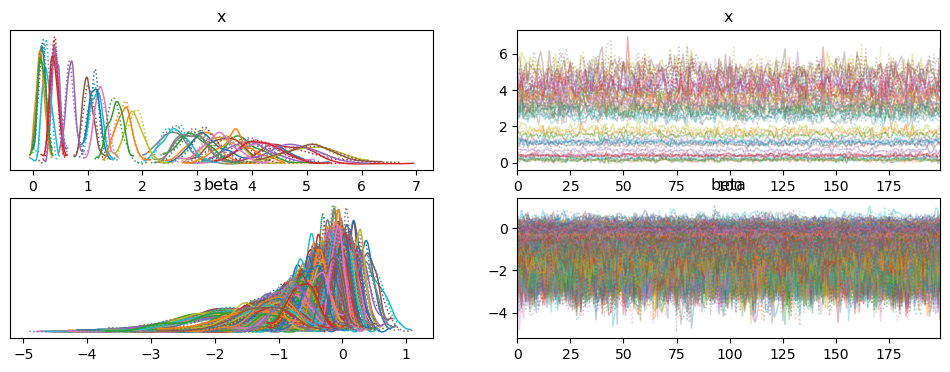

In [8]:
# Échantillonnage postérieur prédictif
posterior_samples = pm.sample_posterior_predictive(trace, model=model)

# Analyser les résultats
pm.summary(trace).round(2)

# Exemple d'analyse : calculer la probabilité d'un vote spécifique
# Remplacez 'vote_index' par l'index du vote spécifique que vous souhaitez évaluer
vote_index = 0
vote_probability = np.mean(posterior_samples["y"][:, :, vote_index])
print(f"Probabilité du vote {vote_index+1}: {vote_probability:.2f}")

# Exemple d'analyse : extraire les échantillons des paramètres
x_samples = trace["x"]
beta_samples = trace["beta"]

# Exemple d'analyse : tracer les distributions postérieures des paramètres
pm.traceplot(trace)


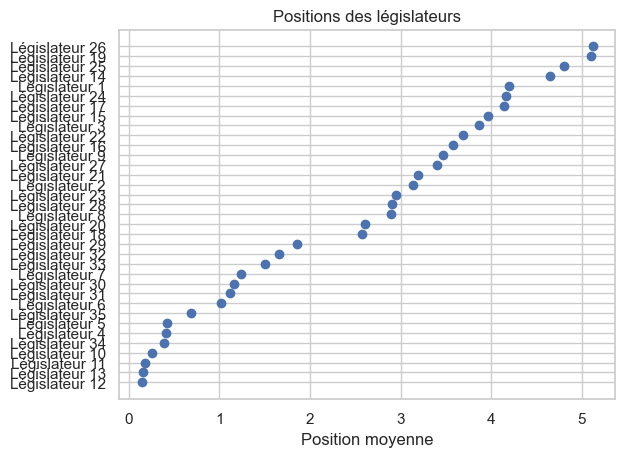

In [58]:
# Exemple d'analyse : extraire les échantillons des paramètres
x_samples = trace["x"]

# Calculer les positions moyennes des législateurs
x_mean = x_samples.mean(axis=0)

# Tri des positions par ordre croissant
sorted_indices = x_mean.argsort()

# Création de l'axe
fig, ax = plt.subplots()

# Définir les positions des législateurs sur l'axe
positions = range(len(x_mean))
labels = [f"Législateur {i+1}" for i in sorted_indices]

# Tracer les positions des législateurs
ax.scatter(x_mean[sorted_indices], positions)

# Étiquettes des législateurs sur l'axe
ax.set_yticks(positions)
ax.set_yticklabels(labels)

# Ajouter un titre et des étiquettes d'axe
ax.set_title("Positions des législateurs")
ax.set_xlabel("Position moyenne")

# Afficher le graphe
plt.show()


In [59]:
# Créer un DataFrame à partir des échantillons de x
x_df = pd.DataFrame(x_mean)

# Réattribuer l'index de df_echantillone à x_df
x_df.index = df_echantillone.index

# Afficher le DataFrame avec l'index de df_echantillone
x_df

,0
identifiant,
PA719822,4.189754
PA720334,3.132245
PA331582,3.868267
PA795794,0.414827
PA794146,0.426631
PA795868,1.020237
PA795998,1.239862
PA793572,2.887046
PA793398,3.463131


In [60]:
# Renommer la colonne
x_df.rename(columns={0: 'MCMC'}, inplace=True)

# Enregistrer dans un fichier CSV
x_df.to_csv('data\\analyseMCMC.csv', index=False)

## 4. Comparaison avec le modèle ACP

Nous comparons notre modèle MCMC avec le Modèle ACP réalisé dans 00_AnalyseVotesDeputesACP.

In [62]:
ACP_df = pd.read_csv("data\\20230503_Data_ACP_Deputes.csv")
ACP_df

,identifiant,Position 1,Position 2,Groupe politique (abrégé),Nom complet
0,PA642868,1.256732,0.308105,HOR,Paul Christophe
1,PA719146,-0.383772,-0.190260,LIOT,Jean-Félix Acquaviva
2,PA795692,-1.179344,-1.330603,LFI - NUPES,William Martinet
3,PA795050,1.158032,-0.016224,RE,Astrid Panosyan-Bouvet
4,PA719412,0.626394,-0.658761,RE,Sandrine Le Feur
...,...,...,...,...,...
572,PA793664,-0.803566,-1.297078,Ecolo - NUPES,Marie Pochon
573,PA721182,0.967948,0.245177,Dem,Frédéric Petit
574,PA757225,0.251567,0.011963,RE,Mikaele Seo
575,PA794802,1.495181,-0.448512,RE,Charles Sitzenstuhl


In [63]:
# Utiliser set_index pour définir la colonne "identifiant" comme nouvel index de ACP_df
ACP_df.set_index('identifiant', inplace=True)

# Utiliser merge pour ajouter les données de ACP_df à x_df en utilisant les index comme clé de répartition
merged_df = x_df.merge(ACP_df, left_index=True, right_index=True)

# Enregistrer dans un fichier CSV
merged_df.to_csv('data\\analyseMCMCvsACP.csv', index=False)

# Enregistrer le DataFrame fusionné dans un fichier CSV
merged_df

,MCMC,Position 1,Position 2,Groupe politique (abrégé),Nom complet
identifiant,,,,,
PA719822,4.189754,0.734088,0.174633,Dem,Sabine Thillaye
PA720334,3.132245,1.286728,-0.176241,Dem,Jimmy Pahun
PA331582,3.868267,0.960087,0.060967,Dem,Philippe Vigier
PA795794,0.414827,-0.770688,-1.020755,Ecolo - NUPES,Francesca Pasquini
PA794146,0.426631,-0.865401,-1.495935,Ecolo - NUPES,Julie Laernoes
PA795868,1.020237,-0.734024,-0.683721,GDR - NUPES,Jean-Victor Castor
PA795998,1.239862,-0.853543,-0.519697,GDR - NUPES,Emeline K/Bidi
PA793572,2.887046,1.182482,-0.007781,HOR,Christophe Plassard
PA793398,3.463131,0.347926,0.278164,HOR,Jérémie Patrier-Leitus


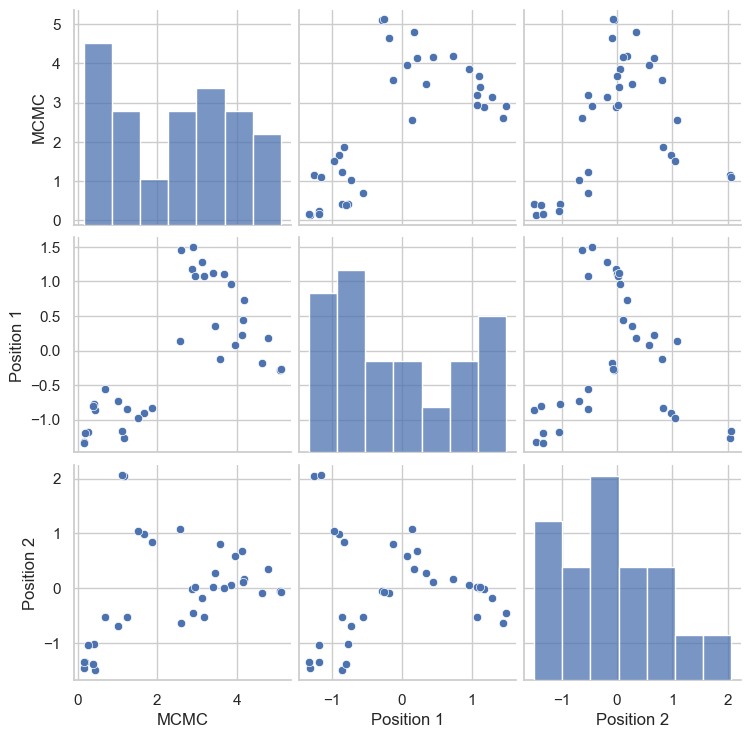

In [64]:
columns_to_analyze = ['MCMC', 'Position 1', 'Position 2']
data_to_analyze = merged_df[columns_to_analyze]

sns.pairplot(data_to_analyze)
plt.show()


In [65]:
# Sélectionnez les colonnes pour l'analyse de corrélation
columns_to_analyze = ['MCMC', 'Position 1', 'Position 2']
data_to_analyze = merged_df[columns_to_analyze]

# Calculer la matrice de corrélation
correlation_matrix = data_to_analyze.corr()

# Afficher la matrice de corrélation
print(correlation_matrix)


                MCMC  Position 1  Position 2
MCMC        1.000000    0.656141    0.362906
Position 1  0.656141    1.000000    0.055040
Position 2  0.362906    0.055040    1.000000


Il semble en effet comme attendu que l'opposition au pouvoir est la principale valeur mesurée.

In [66]:
# Calculer la corrélation entre MCMC et Position 1
corr1, p_value1 = pearsonr(merged_df['MCMC'], merged_df['Position 1'])
print("Corrélation entre MCMC et Position 1:", corr1)
print("p-valeur:", p_value1)

# Calculer la corrélation entre MCMC et Position 2
corr2, p_value2 = pearsonr(merged_df['MCMC'], merged_df['Position 2'])
print("Corrélation entre MCMC et Position 2:", corr2)
print("p-valeur:", p_value2)

# Calculer la corrélation entre Position 1 et Position 2
corr3, p_value3 = pearsonr(merged_df['Position 1'], merged_df['Position 2'])
print("Corrélation entre Position 1 et Position 2:", corr3)
print("p-valeur:", p_value3)


Corrélation entre MCMC et Position 1: 0.6561414648927311
p-valeur: 1.873313841883779e-05
Corrélation entre MCMC et Position 2: 0.3629059790947378
p-valeur: 0.03214051516697711
Corrélation entre Position 1 et Position 2: 0.0550399658141217
p-valeur: 0.7534957537073167


Les résultats obtenus indiquent les coefficients de corrélation et les p-valeurs pour les différentes combinaisons de variables.

Dans la matrice de corrélation :

- Entre MCMC et Position 1, le coefficient de corrélation est de 0,656141, ce qui indique une corrélation positive modérée entre ces deux variables. La p-valeur de 1,8733e-05 est inférieure à 0,05, ce qui suggère que cette corrélation est statistiquement significative.

- Entre MCMC et Position 2, le coefficient de corrélation est de 0,362906, ce qui indique une corrélation positive plus faible entre ces deux variables. La p-valeur de 0,0321 est également inférieure à 0,05, indiquant une corrélation statistiquement significative, mais avec une force plus faible que pour MCMC et Position 1.

- Entre Position 1 et Position 2, le coefficient de corrélation est de 0,05504, ce qui suggère une corrélation très faible, voire inexistante. La p-valeur de 0,7535 est supérieure à 0,05, indiquant l'absence de corrélation statistiquement significative entre ces deux variables.

Les p-valeurs indiquent si la corrélation observée est statistiquement significative ou non. En général, on considère qu'une p-valeur inférieure à 0,05 indique une corrélation statistiquement significative. Dans ce cas, les corrélations entre MCMC et Position 1, ainsi que MCMC et Position 2, sont statistiquement significatives.

Il est important de noter que la corrélation ne signifie pas nécessairement une relation de causalité entre les variables. Les corrélations observées ici indiquent uniquement des relations linéaires entre les variables, mais d'autres facteurs ou mécanismes peuvent être à l'origine de ces relations.

En conclusion, les résultats suggèrent des corrélations significatives entre MCMC et Position 1, ainsi que MCMC et Position 2, avec une corrélation plus forte dans le premier cas. En revanche, il n'y a pas de corrélation significative entre Position 1 et Position 2.

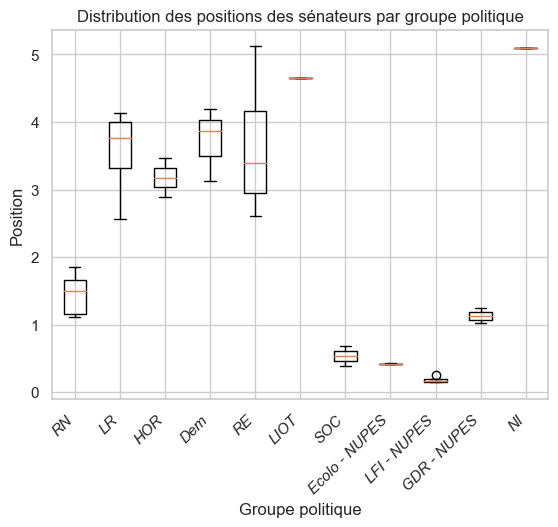

In [67]:
# Définir la couleur du fond du graphique à afficher
sns.set_style("whitegrid")

# Définir l'ordre des groupes politiques en fonction de leur place dans l'émicycle
ordre_groupes = ['RN', 'LR','HOR','Dem', 'RE', 'LIOT', 'SOC', 'Ecolo - NUPES', 'LFI - NUPES', 'GDR - NUPES', 'NI']

# Réorganisation des données selon l'ordre souhaité
dist_df = merged_df.reset_index().set_index("Groupe politique (abrégé)").loc[ordre_groupes]

# Création d'une liste contenant les positions pour chaque groupe politique
positions_par_groupe = [dist_df.loc[g, "MCMC"] for g in ordre_groupes]

# Création du graphique en boîte à moustaches
fig, ax = plt.subplots()
ax.boxplot(positions_par_groupe)

# Ajout des labels et du titre
ax.set_xticklabels(ordre_groupes, rotation=45, ha='right', fontdict={'fontstyle': 'oblique'})
ax.set_xlabel("Groupe politique")
ax.set_ylabel("Position")
ax.set_title("Distribution des positions des députés par groupe politique")

# Affichage du graphique
plt.show()

In [68]:
# Créer une figure 3D
fig = px.scatter_3d(merged_df, x='MCMC', y='Position 1', z='Position 2', color='Groupe politique (abrégé)')

# Ajouter un titre et des étiquettes d'axe
fig.update_layout(title="Graphique 3D interactif",
                  scene=dict(xaxis_title='MCMC', yaxis_title='Position 1', zaxis_title='Position 2'))

# Afficher le graphique interactif
fig.show()
